In [1]:
import os
import pandas as pd
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
import seaborn as sns
from scipy import stats
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler
from sklearn.tree import ExtraTreeClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier,RidgeClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer,TfidfVectorizer,HashingVectorizer
from sklearn.ensemble import GradientBoostingClassifier,AdaBoostClassifier,RandomForestClassifier,HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import tensorflow as tf
# config = tf.compat.v1.ConfigProto()
# config.gpu_options.allow_growth = True
# session =tf.compat.v1.InteractiveSession(config=config)
# physical_devices = tf.config.experimental.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], True)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only allocate 1GB * 2 of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024 * 2)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, MaxPooling1D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.utils import to_categorical
RANDOM_SEED = 2021
import joblib
%matplotlib inline 

1 Physical GPUs, 1 Logical GPUs


In [2]:
def read_data(path):
    data = pd.read_excel(path, header=None)
    data.columns = ['Timestamp', 'Ax', 'Ay', 'Az', 'Gx', 'Gy', 'Gz', 'Label', 'Activity']
    return data

In [3]:
df = read_data('real_data.xlsx')

In [19]:
color ='rgbm' 

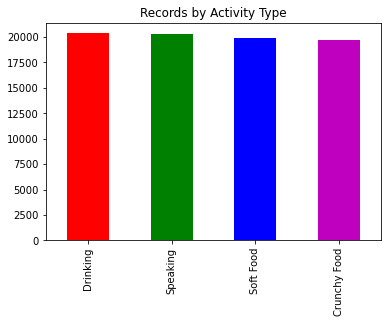

In [24]:
df.Activity.value_counts().plot(kind='bar', color=list(color), title="Records by Activity Type");


In [4]:
df.groupby('Label').apply(lambda x: x.sample(1))

,,Timestamp,Ax,Ay,Az,Gx,Gy,Gz,Label,Activity
Label,,,,,,,,,,
1,18664,1634280000000,-0.960327,-0.161865,-0.112183,-10.182927,0.396341,0.213415,1,Drinking
2,17390,1634280291512,-0.967407,0.058350,-0.195312,-8.201220,1.859756,-8.018293,2,Crunchy Food
3,54378,1634451526087,-0.893311,-0.144165,0.339478,-9.573171,-8.262195,2.408537,3,Soft Food
4,12734,1634264562871,-0.944824,-0.358276,0.118286,-19.481707,1.097561,3.658537,4,Speaking


In [5]:
def get_score(model,x_train,x_test,y_train,y_test,score):
    """Here we want to get the score for each prediction with different scoring metrics, 
      this will be used when we run our cross-validation"""
    
    model.fit(x_train,y_train)
    y_pred = model.predict(x_test)
    from sklearn.metrics import f1_score,accuracy_score,roc_auc_score,precision_score,recall_score
    if score == 'f1_score':
        score =f1_score(y_test,y_pred, average='weighted')
    elif score =='accuracy_score':
        score = accuracy_score(y_test,y_pred)
    elif score =='roc_score':
        score = roc_auc_score(y_test,y_pred)
    elif score =='precision_score':
        score = precision_score(y_test,y_pred)
    else:
        score = recall_score(y_test,y_pred)
    return score

In [6]:
from tqdm import tqdm

In [7]:
def skfold_validate(X,y,score,select_best_3=True):
    """This function is meant to run a kfold cross validation on the data
      with various models and picking the best 3 models based on the 
      defined scoring metrics)"""
      #setting evaluation metrics scoring metrics or short form score
    score = score
    #importing the necessary model modules
    from sklearn.model_selection import KFold, StratifiedKFold
    from sklearn.linear_model import LogisticRegression
    from sklearn.neural_network import MLPClassifier
    from xgboost import XGBClassifier
    from sklearn.svm import SVC
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.experimental import enable_hist_gradient_boosting
    from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier,GradientBoostingClassifier,HistGradientBoostingClassifier
    from catboost import CatBoostClassifier
    from sklearn.naive_bayes import MultinomialNB
    #using  Kfold to perform the splitting
    skfold = StratifiedKFold(n_splits=10,random_state=0,shuffle=True)
#     data = reduce_dimension(data,reduction_model=reduction_model)
#     X = X
#     y = y
    score_log = []
    score_mlp = []
    score_xgb = []
    score_svc = []
    score_ada = []
    score_random = []
    score_gradient = []
    score_decision = []
    score_hist = []
    score_naive = []
    score_nm = []
    score_catboost = []
    model_dict_score = {}
#     X = pd.DataFrame(X)
#     y= pd.Series(y)
#     print(score_log)
    for train_index,test_index in tqdm(skfold.split(X,y), total=skfold.get_n_splits(),desc="sk-fold"):
        x_train,x_test,y_train,y_test=X.iloc[train_index],X.iloc[test_index],y.iloc[train_index],y.iloc[test_index]
        score_log.append(get_score(LogisticRegression(),x_train,x_test,y_train,y_test,score))
        score_mlp.append(get_score(MLPClassifier(early_stopping=True,hidden_layer_sizes=20,max_iter=5000),x_train,x_test,y_train,y_test,score))
        score_xgb.append(get_score(XGBClassifier(),x_train,x_test,y_train,y_test,score))
        score_svc.append(get_score(SVC(),x_train,x_test,y_train,y_test,score))
        score_ada.append(get_score(AdaBoostClassifier(),x_train,x_test,y_train,y_test,score))
        score_random.append(get_score(RandomForestClassifier(),x_train,x_test,y_train,y_test,score))
        score_gradient.append(get_score(GradientBoostingClassifier(),x_train,x_test,y_train,y_test,score))
        score_decision.append(get_score(DecisionTreeClassifier(),x_train,x_test,y_train,y_test,score))
        score_hist.append(get_score(HistGradientBoostingClassifier(),x_train,x_test,y_train,y_test,score))
#         score_naive.append(get_score(MultinomialNB(),x_train,x_test,y_train,y_test,score))
        score_catboost.append(get_score(CatBoostClassifier(),x_train,x_test,y_train,y_test,score))
    model_dict_score['logit_model'] = np.mean(score_log)
    model_dict_score['mlp'] = np.mean(score_mlp)
    model_dict_score['xgb'] = np.mean(score_xgb)
    model_dict_score['svc'] = np.mean(score_svc)
    model_dict_score['random_forest'] = np.mean(score_random)
    model_dict_score['decision_tree'] = np.mean(score_decision)
    #model_dict_score['randomforest'] = np.mean(score_random)
    model_dict_score['adaboost'] = np.mean(score_ada)
    model_dict_score['gradient'] = np.mean(score_gradient)
    model_dict_score['hist'] = np.mean(score_hist)
    model_dict_score['naive'] = np.mean(score_naive)
    model_dict_score['catboost'] = np.mean(score_catboost)
    model_df = pd.DataFrame(model_dict_score.items())
    model_df.columns = ['model','scores']
    if select_best_3:
        df = model_df.sort_values(by='scores',ascending=False).head(3).reset_index(drop=True)
    else:
        df = model_df.sort_values(by='scores',ascending=False).reset_index(drop=True)
    return df

In [9]:
def preprocess_data(df: pd.DataFrame, *args) -> pd.DataFrame:
    df_new = df.copy()
    columns = list(args)
    df_new.drop(['Timestamp','Activity'], axis=1, inplace=True)
    df_new = df_new.sample(len(df_new))
#     min_max = MinMaxScaler()
#     df_new[columns] = min_max.fit_transform(df_new[columns])
    return df_new

In [10]:
df_new = preprocess_data(df, 'Ax', 'Ay', 'Az', 'Gx', 'Gy', 'Gz',)

In [13]:
model_rf = joblib.load('model_ref.pkl')

In [14]:
X = df_new.drop('Label', axis=1)
y = df_new['Label']

In [15]:
X.head()

,Ax,Ay,Az,Gx,Gy,Gz
62204,-0.834473,-0.450684,0.327148,1.646341,3.323171,0.823171
16676,-0.983276,0.106689,-0.227051,-11.128049,-7.896341,-8.963415
30472,-0.962280,0.057983,-0.208984,-5.945122,-8.475610,-9.542683
38197,-0.737915,0.592285,-0.180176,2.987805,-9.481707,-4.207317
14206,-0.972656,-0.327148,0.101440,0.487805,-9.817073,-41.798780


In [16]:
df = skfold_validate(X, y, 'f1_score', select_best_3=False)

sk-fold:   0%|                                                                                  | 0/10 [00:00<?, ?it/s]C:\Users\id\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\id\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, .

[18:09:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Learning rate set to 0.098428
0:	learn: 1.3455871	total: 179ms	remaining: 2m 59s
1:	learn: 1.3071543	total: 209ms	remaining: 1m 44s
2:	learn: 1.2794477	total: 232ms	remaining: 1m 16s
3:	learn: 1.2554391	total: 255ms	remaining: 1m 3s
4:	learn: 1.2289171	total: 278ms	remaining: 55.4s
5:	learn: 1.2116404	total: 303ms	remaining: 50.1s
6:	learn: 1.1936471	total: 324ms	remaining: 45.9s
7:	learn: 1.1770184	total: 344ms	remaining: 42.7s
8:	learn: 1.1612621	total: 370ms	remaining: 40.7s
9:	learn: 1.1489509	total: 392ms	remaining: 38.8s
10:	learn: 1.1336592	total: 414ms	remaining: 37.3s
11:	learn: 1.1205415	total: 437ms	remaining: 36s
12:	learn: 1.1078431	total: 461ms	remaining: 35s
13:	lea

sk-fold:  10%|███████                                                                | 1/10 [10:38<1:35:43, 638.16s/it]

998:	learn: 0.5366382	total: 25.1s	remaining: 25.1ms
999:	learn: 0.5365167	total: 25.1s	remaining: 0us


C:\Users\id\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\id\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:19:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Learning rate set to 0.098428
0:	learn: 1.3429351	total: 30.1ms	remaining: 30s
1:	learn: 1.3074572	total: 50.2ms	remaining: 25.1s
2:	learn: 1.2756842	total: 74.3ms	remaining: 24.7s
3:	learn: 1.2519186	total: 95.4ms	remaining: 23.8s
4:	learn: 1.2261162	total: 116ms	remaining: 23.1s
5:	learn: 1.2074842	total: 143ms	remaining: 23.6s
6:	learn: 1.1884015	total: 165ms	remaining: 23.3s
7:	learn: 1.1728307	total: 186ms	remaining: 23s
8:	learn: 1.1574735	total: 206ms	remaining: 22.7s
9:	learn: 1.1437993	total: 227ms	remaining: 22.5s
10:	learn: 1.1314334	total: 247ms	remaining: 22.2s
11:	learn: 1.1186355	total: 270ms	remaining: 22.3s
12:	learn: 1.1072817	total: 291ms	remaining: 22.1s
13:	le

sk-fold:  20%|██████████████▏                                                        | 2/10 [21:15<1:25:04, 638.00s/it]

998:	learn: 0.5349856	total: 26.7s	remaining: 26.7ms
999:	learn: 0.5348833	total: 26.7s	remaining: 0us


C:\Users\id\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\id\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:30:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Learning rate set to 0.098428
0:	learn: 1.3435137	total: 64.3ms	remaining: 1m 4s
1:	learn: 1.3074184	total: 98.2ms	remaining: 49s
2:	learn: 1.2777546	total: 137ms	remaining: 45.7s
3:	learn: 1.2537720	total: 176ms	remaining: 43.8s
4:	learn: 1.2263175	total: 215ms	remaining: 42.7s
5:	learn: 1.2065780	total: 252ms	remaining: 41.8s
6:	learn: 1.1867307	total: 286ms	remaining: 40.5s
7:	learn: 1.1704307	total: 324ms	remaining: 40.1s
8:	learn: 1.1546956	total: 364ms	remaining: 40s
9:	learn: 1.1413230	total: 405ms	remaining: 40s
10:	learn: 1.1299697	total: 437ms	remaining: 39.3s
11:	learn: 1.1158884	total: 466ms	remaining: 38.3s
12:	learn: 1.1041802	total: 497ms	remaining: 37.7s
13:	learn:

sk-fold:  30%|█████████████████████▎                                                 | 3/10 [40:22<1:32:14, 790.61s/it]C:\Users\id\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\id\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, .

[18:49:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Learning rate set to 0.098428
0:	learn: 1.3440522	total: 53.5ms	remaining: 53.4s
1:	learn: 1.3072112	total: 79.8ms	remaining: 39.8s
2:	learn: 1.2751259	total: 108ms	remaining: 35.8s
3:	learn: 1.2514388	total: 133ms	remaining: 33.1s
4:	learn: 1.2280877	total: 159ms	remaining: 31.6s
5:	learn: 1.2094719	total: 186ms	remaining: 30.8s
6:	learn: 1.1920348	total: 214ms	remaining: 30.3s
7:	learn: 1.1742926	total: 246ms	remaining: 30.5s
8:	learn: 1.1557763	total: 281ms	remaining: 31s
9:	learn: 1.1429905	total: 312ms	remaining: 30.8s
10:	learn: 1.1319177	total: 344ms	remaining: 30.9s
11:	learn: 1.1205901	total: 373ms	remaining: 30.8s
12:	learn: 1.1069617	total: 440ms	remaining: 33.4s
13:	le

sk-fold:  40%|███████████████████████████▌                                         | 4/10 [1:02:39<1:35:26, 954.39s/it]

999:	learn: 0.5378298	total: 30.7s	remaining: 0us


C:\Users\id\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\id\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:11:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Learning rate set to 0.098428
0:	learn: 1.3439789	total: 22.6ms	remaining: 22.6s
1:	learn: 1.3067531	total: 43.7ms	remaining: 21.8s
2:	learn: 1.2778553	total: 65ms	remaining: 21.6s
3:	learn: 1.2501192	total: 86.3ms	remaining: 21.5s
4:	learn: 1.2249204	total: 108ms	remaining: 21.5s
5:	learn: 1.2063380	total: 130ms	remaining: 21.5s
6:	learn: 1.1870154	total: 153ms	remaining: 21.7s
7:	learn: 1.1712121	total: 176ms	remaining: 21.9s
8:	learn: 1.1533219	total: 201ms	remaining: 22.1s
9:	learn: 1.1414183	total: 229ms	remaining: 22.7s
10:	learn: 1.1311560	total: 252ms	remaining: 22.7s
11:	learn: 1.1177968	total: 274ms	remaining: 22.6s
12:	learn: 1.1065228	total: 296ms	remaining: 22.5s
13:	

sk-fold:  50%|██████████████████████████████████▌                                  | 5/10 [1:15:56<1:15:36, 907.31s/it]C:\Users\id\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\id\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, .

[19:24:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Learning rate set to 0.098428
0:	learn: 1.3455332	total: 29.3ms	remaining: 29.3s
1:	learn: 1.3072612	total: 52.9ms	remaining: 26.4s
2:	learn: 1.2764976	total: 79ms	remaining: 26.3s
3:	learn: 1.2528714	total: 103ms	remaining: 25.7s
4:	learn: 1.2277416	total: 130ms	remaining: 25.8s
5:	learn: 1.2089011	total: 164ms	remaining: 27.2s
6:	learn: 1.1910200	total: 197ms	remaining: 28s
7:	learn: 1.1748826	total: 229ms	remaining: 28.4s
8:	learn: 1.1566795	total: 259ms	remaining: 28.5s
9:	learn: 1.1414995	total: 287ms	remaining: 28.4s
10:	learn: 1.1306277	total: 310ms	remaining: 27.9s
11:	learn: 1.1204666	total: 332ms	remaining: 27.3s
12:	learn: 1.1066188	total: 354ms	remaining: 26.9s
13:	lea

sk-fold:  60%|██████████████████████████████████████████▌                            | 6/10 [1:27:49<56:36, 849.10s/it]C:\Users\id\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\id\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, .

[19:36:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Learning rate set to 0.098428
0:	learn: 1.3440754	total: 28ms	remaining: 28s
1:	learn: 1.3084039	total: 54.1ms	remaining: 27s
2:	learn: 1.2780270	total: 76ms	remaining: 25.3s
3:	learn: 1.2522089	total: 97.8ms	remaining: 24.3s
4:	learn: 1.2286237	total: 119ms	remaining: 23.7s
5:	learn: 1.2064641	total: 143ms	remaining: 23.7s
6:	learn: 1.1871580	total: 167ms	remaining: 23.7s
7:	learn: 1.1684508	total: 190ms	remaining: 23.5s
8:	learn: 1.1557347	total: 211ms	remaining: 23.3s
9:	learn: 1.1406831	total: 234ms	remaining: 23.2s
10:	learn: 1.1250679	total: 257ms	remaining: 23.1s
11:	learn: 1.1146793	total: 279ms	remaining: 23s
12:	learn: 1.1027260	total: 304ms	remaining: 23.1s
13:	learn: 1

sk-fold:  70%|█████████████████████████████████████████████████▋                     | 7/10 [1:40:38<41:15, 825.01s/it]

997:	learn: 0.5351190	total: 25.4s	remaining: 51ms
998:	learn: 0.5349978	total: 25.5s	remaining: 25.5ms
999:	learn: 0.5348905	total: 25.5s	remaining: 0us


C:\Users\id\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\id\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:50:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Learning rate set to 0.098428
0:	learn: 1.3456472	total: 30.6ms	remaining: 30.5s
1:	learn: 1.3094975	total: 57.4ms	remaining: 28.6s
2:	learn: 1.2753556	total: 86.1ms	remaining: 28.6s
3:	learn: 1.2494856	total: 125ms	remaining: 31s
4:	learn: 1.2260513	total: 166ms	remaining: 33s
5:	learn: 1.2032061	total: 203ms	remaining: 33.6s
6:	learn: 1.1846790	total: 232ms	remaining: 33s
7:	learn: 1.1684507	total: 257ms	remaining: 31.9s
8:	learn: 1.1523772	total: 284ms	remaining: 31.3s
9:	learn: 1.1382123	total: 312ms	remaining: 30.9s
10:	learn: 1.1256913	total: 338ms	remaining: 30.4s
11:	learn: 1.1129224	total: 366ms	remaining: 30.1s
12:	learn: 1.1017292	total: 391ms	remaining: 29.7s
13:	learn

sk-fold:  80%|████████████████████████████████████████████████████████▊              | 8/10 [1:57:05<29:07, 873.71s/it]

999:	learn: 0.5356546	total: 28.4s	remaining: 0us


C:\Users\id\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\id\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:06:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Learning rate set to 0.098428
0:	learn: 1.3437635	total: 40.9ms	remaining: 40.8s
1:	learn: 1.3066109	total: 80.7ms	remaining: 40.3s
2:	learn: 1.2756508	total: 119ms	remaining: 39.7s
3:	learn: 1.2507735	total: 148ms	remaining: 36.9s
4:	learn: 1.2258891	total: 175ms	remaining: 34.9s
5:	learn: 1.2070030	total: 200ms	remaining: 33.2s
6:	learn: 1.1873105	total: 230ms	remaining: 32.7s
7:	learn: 1.1720845	total: 256ms	remaining: 31.8s
8:	learn: 1.1545163	total: 283ms	remaining: 31.2s
9:	learn: 1.1418050	total: 309ms	remaining: 30.6s
10:	learn: 1.1250486	total: 342ms	remaining: 30.7s
11:	learn: 1.1122973	total: 367ms	remaining: 30.2s
12:	learn: 1.1031266	total: 391ms	remaining: 29.7s
13:	

sk-fold:  90%|███████████████████████████████████████████████████████████████▉       | 9/10 [2:12:03<14:40, 880.74s/it]

999:	learn: 0.5362616	total: 26.5s	remaining: 0us


C:\Users\id\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\id\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:21:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Learning rate set to 0.098428
0:	learn: 1.3431860	total: 23.7ms	remaining: 23.7s
1:	learn: 1.3099426	total: 43.6ms	remaining: 21.8s
2:	learn: 1.2784606	total: 65.2ms	remaining: 21.7s
3:	learn: 1.2547917	total: 85.5ms	remaining: 21.3s
4:	learn: 1.2303645	total: 105ms	remaining: 20.9s
5:	learn: 1.2082401	total: 130ms	remaining: 21.6s
6:	learn: 1.1844382	total: 153ms	remaining: 21.7s
7:	learn: 1.1690463	total: 173ms	remaining: 21.4s
8:	learn: 1.1517930	total: 197ms	remaining: 21.7s
9:	learn: 1.1388778	total: 216ms	remaining: 21.4s
10:	learn: 1.1271470	total: 236ms	remaining: 21.2s
11:	learn: 1.1138737	total: 264ms	remaining: 21.8s
12:	learn: 1.1023540	total: 285ms	remaining: 21.6s
13

sk-fold: 100%|██████████████████████████████████████████████████████████████████████| 10/10 [2:22:25<00:00, 854.59s/it]

998:	learn: 0.5353749	total: 21s	remaining: 21ms
999:	learn: 0.5352459	total: 21s	remaining: 0us



C:\Users\id\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\id\anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [18]:
df.columns = ['model','f1_score']

In [21]:
df

,model,f1_score
0,random_forest,0.824579
1,xgb,0.764197
2,catboost,0.761282
3,hist,0.751612
4,decision_tree,0.740229
5,gradient,0.674518
6,adaboost,0.556570
7,mlp,0.459353
8,svc,0.366000
9,logit_model,0.331321


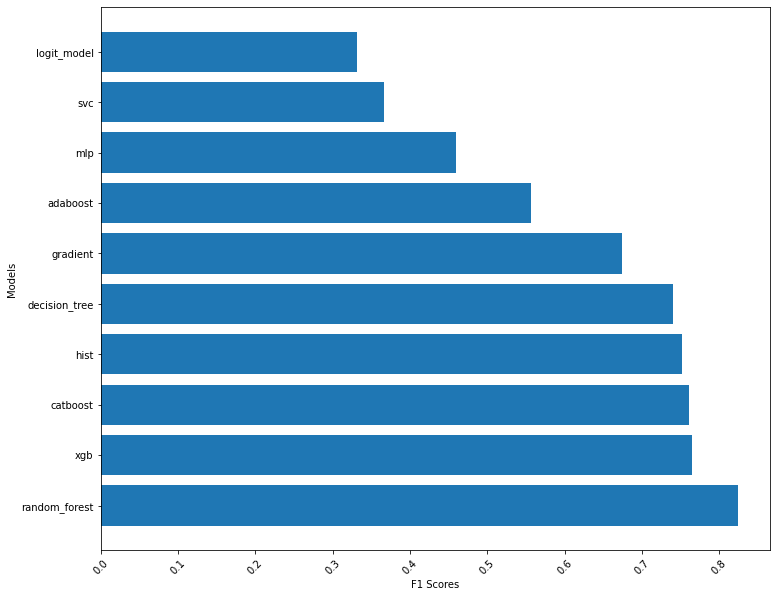

In [28]:
plt.figure(figsize=(12,10))
plt.barh(df['model'],df['f1_score'])
plt.xticks(rotation=45)
plt.ylabel('Models')
plt.xlabel('F1 Scores')
plt.show()

In [ ]:
X_new = X.drop(['Label','Activity'], axis=1)
y = X['Label']

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 200, stop=2000, num= 10)]
max_features = ['auto','sqrt']

max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_sample_split = [2,5,10]
min_sample_leaf = [1,2,4]

bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
              'max_features': max_features,
              'max_depth': max_depth,
              'min_samples_split': min_sample_split,
              'min_samples_leaf': min_sample_leaf,
              'bootstrap':bootstrap}

In [ ]:
rf_random = RandomizedSearchCV(**random_grid)

In [420]:
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [428]:
rf_random.best_params_

{'n_estimators': 1400,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 40,
 'bootstrap': False}

In [ ]:
rf_new = RandomForestClassifier(**{'n_estimators': 1400,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 40,
 'bootstrap': False})

In [38]:
X = df_new.drop(['Label'], axis=1)
y = df_new['Label']

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=20)

In [ ]:
rf_new.fit(X_train, y_train)

In [52]:
joblib.dump(model, 'model_ref.pkl', compress=3)

['model_ref.pkl']

In [40]:
rf_new = RandomForestClassifier(**{'n_estimators': 1400,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 40,
 'bootstrap': False})

In [49]:
rf_new.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, max_depth=60, n_estimators=5000)

In [15]:
joblib.dump(rf_new, 'model_rf', compress=3)

['model_rf']

In [ ]:
model_rf = joblib.load('model_rf')

In [58]:
print(classification_report(model_rf.predict(X_test), y_test))

              precision    recall  f1-score   support

           1       0.96      0.96      0.96      6090
           2       0.93      0.94      0.94      5792
           3       0.94      0.93      0.94      6031
           4       0.95      0.94      0.95      6166

    accuracy                           0.95     24079
   macro avg       0.95      0.95      0.95     24079
weighted avg       0.95      0.95      0.95     24079



In [45]:
def plot_confusion_matrix(model,X_test,y_test,title) ->None:
    from sklearn.metrics import confusion_matrix
#     model.fit(X_train,y_train)
    pred = model.predict(X_test)
    
    cm = confusion_matrix(pred,y_test)
    df_cm = pd.DataFrame(cm.T, index=range(4),columns=range(4))
    sns.set(font_scale=1.4)
    sns.heatmap(df_cm, annot=True, annot_kws={"size":16}, fmt="",cbar=False)
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.title(title)
    plt.show()

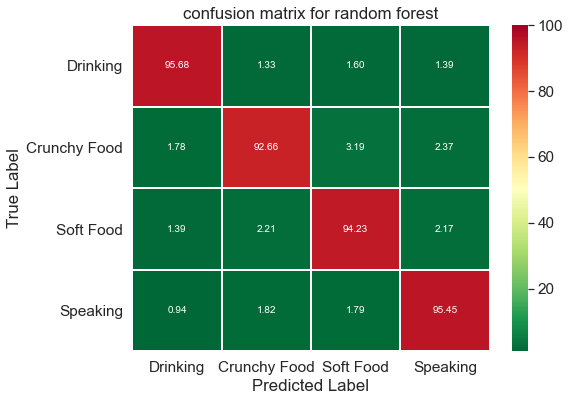

In [60]:
plot_confusion_matrix(model_rf, X_test, y_test, 'confusion matrix for random forest')

In [63]:
model_rf.get_params()

{'bootstrap': False,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 40,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1400,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [6]:
import requests

url = 'https://harmodel-jssgkupp2q-uc.a.run.app/predict_activity'

pred = requests.post(url, json= {'Timestamp': 1634248549613, 'Ax': -1.01318359375,
                                 'Ay': 0.0396728515625,
                                 'Az': -0.1058349609375,
                                 'Gx': -4.2682926829268295,
                                 'Gy': -11.432926829268293,
                                 'Gz': 1.1890243902439026})

In [7]:
pred.json()

{'output_prediction': 'Cruncy Food'}

In [31]:
pd.DataFrame([{'Timestamp': 1634248549613, 'Ax': -1.01318359375,
                                 'Ay': 0.0396728515625,
                                 'Az': -0.1058349609375,
                                 'Gx': -4.2682926829268295,
                                 'Gy': -11.432926829268293,
                                 'Gz': 1.1890243902439026}]).drop('Timestamp', axis=1)

,Ax,Ay,Az,Gx,Gy,Gz
0,-1.013184,0.039673,-0.105835,-4.268293,-11.432927,1.189024
